In [1]:
import pandas as pd
import openpyxl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
import pingouin as pg

file_name = "INF2178_A3_data.csv"
df_original = pd.read_csv(file_name)
df = df_original

#Function to standardize column names using a names dictionary
def standardize_column_names(data_frame, names_dictionary):
    data_frame.rename(columns=names_dictionary, inplace=True)

#Function to convert columns to a specified data type
def convert_cols(data_frame, conversion_type, lst_of_cols):
    if conversion_type.lower() == "number":
        for col in lst_of_cols:
            data_frame[col] = pd.to_numeric(df[col], errors="coerce")
    if conversion_type.lower() == "datetime":
        for col in lst_of_cols:
            data_frame[col] = pd.to_datetime(df[col], errors="coerce")

#Function to check for empty cells in dataframe
def empty_cells_exist(data_frame):
    is_df_empty = data_frame.isna().any().to_list()
    if True in is_df_empty:
        return True
    return False

#Function to create plots for linearity and homogenity
def check_linearity_homogeneity_no_subplots(data_frame, x_col, y_col, hue_col, title):
    plot = sns.lmplot(x=x_col, y=y_col, hue=hue_col, data=data_frame, ci=None, palette="muted", height=6, aspect=2, scatter_kws={"facecolors": "none", "edgecolors": "muted"})
    #scatter_kws={"alpha": 0.3})
    plt.title(title)
    plt.show()

def check_linearity_homogeneity_subplots(data_frame, x_col, y_col, hue_col, title,
                                alpha=1):
    categories = data_frame[hue_col].unique()
    palette = sns.color_palette("muted", len(categories))
    fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
    legend_lists = []
    for i, category in enumerate(categories):
        subset = data_frame[data_frame[hue_col] == category]
        axes[0].scatter(subset[x_col], subset[y_col], label=category, edgecolors=palette[i], facecolors='none', alpha=alpha)

        sns.regplot(x=x_col, y=y_col, data=subset, scatter=False, color=palette[i], ci=None, ax=axes[1])

        legend_lst = mlines.Line2D([], [], color=palette[i], label=category)
        legend_lists.append(legend_lst)

    axes[0].set_title(title)
    axes[1].set_title(title)

    for ax in axes:
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)

    axes[0].legend(title=hue_col)
    axes[1].legend(handles=legend_lists, title=hue_col)
    fig.subplots_adjust(wspace=3)
    plt.tight_layout()
    plt.show()


#Function to run ANCOVA
def run_ancova(data_frame, ancova_statement):
    model = ols(ancova_statement, data=data_frame).fit()
    predictions = model.fittedvalues
    residuals = model.resid
    ancova_results = anova_lm(model, typ=2)
    return [model, predictions, residuals, ancova_results]

#Function to run Shapiro and Levene tests
def run_shapiro_levene(data_frame, residuals, dependent_var, independent_var):
    independent_var_level = sorted(data_frame[independent_var].unique().tolist())
    levene_test_results = stats.levene(data_frame[dependent_var][data_frame[independent_var] == independent_var_level[0]], data_frame[dependent_var][data_frame[independent_var] == independent_var_level[1]], data_frame[dependent_var][data_frame[independent_var] == independent_var_level[2]])
    shapiro_test_results = stats.shapiro(residuals)
    combined_results = pd.DataFrame({
    "Test": [f"Shapiro-Wilk ({dependent_var})",
             f"Levene ({dependent_var})"],
    "Statistic": [shapiro_test_results.statistic, levene_test_results.statistic],
    "p-value": [shapiro_test_results.pvalue, levene_test_results.pvalue]
    })
    return combined_results

#Function to get descriptive statistics of the DataFrame
def get_descriptive_stats(data_frame, all=False, lst_of_columns=[]):
    if all == True:
        # Getting descriptive statistics for all columns
        descriptive_stats = data_frame.describe(include="all")
        descriptive_stats_df = descriptive_stats.transpose()
    if all == False:
        # Getting descriptive statistics for specified columns
        descriptive_stats = data_frame[lst_of_columns].describe()
        descriptive_stats_df = descriptive_stats.transpose()
    return descriptive_stats_df

def melt_me(data_frame, variable_name, val_name, id_variables=[],
            value_variables=[]):
    melted_df = pd.melt(data_frame, id_vars=id_variables,
                        value_vars=value_variables, var_name=variable_name, value_name=val_name)
    return melted_df

#Function to check if a column follows a normal distribution
def is_col_normal(data_frame, col_name):
    cleaned_df = data_frame[col_name]
    plt.figure(figsize=(12, 5))

    #Creating a histogram of the column
    plt.subplot(1, 2, 1)
    sns.histplot(cleaned_df, kde=True, bins=30)
    plt.title(f"Histogram of {col_name}")

    #Creating a box plot of the column
    plt.subplot(1, 2, 2)
    sns.boxplot(x=cleaned_df)
    plt.title(f"Boxplot of {col_name}")

    #Calculating mean, median, quartiles, and IQR
    mean = cleaned_df.mean()
    median = cleaned_df.median()
    quartiles = cleaned_df.quantile([0.25, 0.75])
    iqr = quartiles[0.75] - quartiles[0.25]
    stats = {"Mean":mean,"Median":median,"Quartile1":quartiles[0.25],"Quartile3":quartiles[0.75],"IQR":iqr}

    plt.tight_layout()
    plt.show()
    return stats

#Function to generate QQ plots of one-way ANCOVA model residuals
def generate_qq_plot(residuals, title, y_axis_label):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    sm.qqplot(residuals, line="s", fit=True, ax=ax)
    #stats.probplot(residuals, dist="norm", plot=plt)
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel(f"Standardized Residuals ({y_axis_label})")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5, color="gray")
    for line in ax.lines:
        line.set_markerfacecolor("white")
        line.set_markeredgecolor("gray")
        line.set_markeredgewidth(1.0)
        line.set_markersize(5)
    plt.title(title)
    plt.show()

#Function to generate histogram of one-way ANCOVA model residuals
def generate_histogram(residuals, title):
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins="auto", histtype="bar", ec="k", density=True, alpha=0.6, color="gray")
    #Overlay the standard normal distribution
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, residuals.mean(), residuals.std())
    plt.plot(x, p, "k", linewidth=2)
    #title = "Fit results: mu = %.2f,  std = %.2f" % (residuals.mean(), residuals.std())
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5, color="gray")
    plt.title(title)
    plt.show()

#Function to generate boxplots
def generate_box_plot(melted_data_frame, independent_var,
                      x_var, y_var, figx, figy,plot_title, legend_title, x_ticks_rotation, palette_val="Set3"):
    plt.figure(figsize=(figx, figy))
    sns.set_style("whitegrid")
    sns.boxplot(x=x_var, y=y_var, hue=independent_var, data=melted_data_frame, palette=palette_val, linewidth=1.5)
    plt.title(plot_title)
    plt.xticks(rotation=x_ticks_rotation)
    plt.legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout(rect=[0,0,0.85,1])

    grouped = melted_data_frame.groupby([x_var, independent_var])
    stats = grouped[y_var].describe()
    means = grouped[y_var].mean()
    stats_results_lst = []
    for (group, sub_df) in grouped:
        iqr = sub_df[y_var].quantile(0.75) - sub_df[y_var].quantile(0.25)
        mean = means[group]
        median = sub_df[y_var].median()
        stats_results_lst.append({
            "Type": group[1],
            "Income": group[0],
            "IQR": iqr,
            "Mean": mean,
            "Median": median
        })
        # print(f"Group: {group}, IQR: {iqr}, Mean: {mean}, Median: {median}")

    plt.tight_layout()
    plt.show()
    return stats_results_lst

#Check to ensure there are no empty cells
if empty_cells_exist(df) == False:
    #Convert cols to number
    convert_cols(df, "number", df.columns.tolist())
    #Rename columns for stylistic reasons
    new_col_names = {
        "fallreadingscore": "Fall_Reading_Score",
        "fallmathscore": "Fall_Math_Score",
        "fallgeneralknowledgescore": "Fall_General_Knowledge_Score",
        "springreadingscore": "Spring_Reading_Score",
        "springmathscore": "Spring_Math_Score",
        "springgeneralknowledgescore": "Spring_General_Knowledge_Score",
        "totalhouseholdincome": "Total_Household_Income",
        "incomeinthousands": "Total_Household_Income_in_Thousands",
        "incomegroup": "Income_Group"
    }
    standardize_column_names(df, new_col_names)
else:
    print("Dataframe contains empty cells, data cleaning required")

def output_to_csv(data_frame, file_name):
    new_csv_filepath = "cleaned_data.csv"
    data_frame.to_csv(new_csv_filepath, index=False)

df.head()


,Fall_Reading_Score,Fall_Math_Score,Fall_General_Knowledge_Score,Spring_Reading_Score,Spring_Math_Score,Spring_General_Knowledge_Score,Total_Household_Income,Total_Household_Income_in_Thousands,Income_Group
0,36.58,39.54,33.822,49.37,50.10,40.533,140000.0,140.0,3
1,50.82,44.44,38.147,83.50,58.93,37.409,120000.0,120.0,3
2,40.68,28.57,28.108,40.41,32.81,29.312,90000.0,90.0,3
3,32.57,23.57,15.404,34.14,35.25,27.382,50000.0,50.0,2
4,31.98,19.65,18.727,32.84,23.60,26.977,55000.0,55.0,2


In [2]:
num_rows = df.shape[0]
num_columns = df.shape[1]

num_rows_cols_info_df = pd.DataFrame({
    "Description": ["Number of Rows", "Number of Columns"],
    "Value": [num_rows, num_columns]})

num_rows_cols_info_df


,Description,Value
0,Number of Rows,11933
1,Number of Columns,9


In [3]:
if empty_cells_exist(df) == False:
    print("There are no empty cells in the dataframe.")
else:
    print("There are empty cells in the dataframe.")


There are no empty cells in the dataframe.


In [4]:
missing_values = df.isnull().sum()
missing_values_df = missing_values.reset_index()
missing_values_df.columns = ["Column Name", "Number of Missing Values"]
missing_values_df


,Column Name,Number of Missing Values
0,Fall_Reading_Score,0
1,Fall_Math_Score,0
2,Fall_General_Knowledge_Score,0
3,Spring_Reading_Score,0
4,Spring_Math_Score,0
5,Spring_General_Knowledge_Score,0
6,Total_Household_Income,0
7,Total_Household_Income_in_Thousands,0
8,Income_Group,0


In [5]:
income_groups = df.groupby("Income_Group")["Total_Household_Income"].agg(["min", "max"]).reset_index()

income_groups


,Income_Group,min,max
0,1,1.0,39800.0
1,2,40000.0,69700.0
2,3,70000.0,150000.0


In [6]:
income_group_mapping = {
    1: "1.0-39800",
    2: "40000-69700",
    3: "70000-150000"
}
df["Income_Group_in_Numbers"] = df["Income_Group"].map(income_group_mapping)
df.head()


,Fall_Reading_Score,Fall_Math_Score,Fall_General_Knowledge_Score,Spring_Reading_Score,Spring_Math_Score,Spring_General_Knowledge_Score,Total_Household_Income,Total_Household_Income_in_Thousands,Income_Group,Income_Group_in_Numbers
0,36.58,39.54,33.822,49.37,50.10,40.533,140000.0,140.0,3,70000-150000
1,50.82,44.44,38.147,83.50,58.93,37.409,120000.0,120.0,3,70000-150000
2,40.68,28.57,28.108,40.41,32.81,29.312,90000.0,90.0,3,70000-150000
3,32.57,23.57,15.404,34.14,35.25,27.382,50000.0,50.0,2,40000-69700
4,31.98,19.65,18.727,32.84,23.60,26.977,55000.0,55.0,2,40000-69700


In [7]:
missing_values = df.isnull().sum()
missing_values_df = missing_values.reset_index()
missing_values_df.columns = ["Column Name", "Number of Missing Values"]
missing_values_df


,Column Name,Number of Missing Values
0,Fall_Reading_Score,0
1,Fall_Math_Score,0
2,Fall_General_Knowledge_Score,0
3,Spring_Reading_Score,0
4,Spring_Math_Score,0
5,Spring_General_Knowledge_Score,0
6,Total_Household_Income,0
7,Total_Household_Income_in_Thousands,0
8,Income_Group,0
9,Income_Group_in_Numbers,0


In [8]:
#Add additional columns to calculate change in the following:
    #"Change_in_Reading_Score"
    #"Change_in_Math_Score"
    #"Change_in_General_Knowledge_Score"

df["Change_in_General_Knowledge_Score"] = \
    df["Spring_General_Knowledge_Score"] - df["Fall_General_Knowledge_Score"]

df["Change_in_Reading_Score"] = \
    df["Spring_Reading_Score"] - df["Fall_Reading_Score"]

df["Change_in_Math_Score"] = df["Spring_Math_Score"] - df["Fall_Math_Score"]

df.head()


,Fall_Reading_Score,Fall_Math_Score,Fall_General_Knowledge_Score,Spring_Reading_Score,Spring_Math_Score,Spring_General_Knowledge_Score,Total_Household_Income,Total_Household_Income_in_Thousands,Income_Group,Income_Group_in_Numbers,Change_in_General_Knowledge_Score,Change_in_Reading_Score,Change_in_Math_Score
0,36.58,39.54,33.822,49.37,50.10,40.533,140000.0,140.0,3,70000-150000,6.711,12.79,10.56
1,50.82,44.44,38.147,83.50,58.93,37.409,120000.0,120.0,3,70000-150000,-0.738,32.68,14.49
2,40.68,28.57,28.108,40.41,32.81,29.312,90000.0,90.0,3,70000-150000,1.204,-0.27,4.24
3,32.57,23.57,15.404,34.14,35.25,27.382,50000.0,50.0,2,40000-69700,11.978,1.57,11.68
4,31.98,19.65,18.727,32.84,23.60,26.977,55000.0,55.0,2,40000-69700,8.250,0.86,3.95


In [9]:
#Descriptive statistics for continuous variables

all_columns = df.columns.to_list()
continous_cols = all_columns[:]
continous_cols.remove("Income_Group")
continous_cols.remove("Income_Group_in_Numbers")
descriptive_stats_all_cols_df = get_descriptive_stats(df, False, continous_cols)
descriptive_stats_all_cols_df


,count,mean,std,min,25%,50%,75%,max
Fall_Reading_Score,11933.0,35.954215,10.473130,21.010,29.340,34.060,39.890,138.510
Fall_Math_Score,11933.0,27.128244,9.120505,10.510,20.680,25.680,31.590,115.650
Fall_General_Knowledge_Score,11933.0,23.073694,7.396978,6.985,17.385,22.954,28.305,47.691
Spring_Reading_Score,11933.0,47.511178,14.327111,22.350,38.950,45.320,51.770,156.850
Spring_Math_Score,11933.0,37.799461,12.027753,11.900,29.270,36.410,44.220,113.800
Spring_General_Knowledge_Score,11933.0,28.235584,7.577457,7.858,22.802,28.583,33.782,48.345
Total_Household_Income,11933.0,54317.199930,36639.061147,1.000,27000.000,47000.000,72000.000,150000.000
Total_Household_Income_in_Thousands,11933.0,54.317200,36.639061,0.001,27.000,47.000,72.000,150.000
Change_in_General_Knowledge_Score,11933.0,5.161890,4.054906,-14.183,2.472,5.047,7.781,27.785
Change_in_Reading_Score,11933.0,11.556963,8.085004,-44.760,6.470,10.400,15.150,91.940


In [10]:
#Descriptive statistics for categorical variables

income_group_freq = df["Income_Group_in_Numbers"].value_counts().reset_index()
income_group_freq.columns = ["Income_Group_in_Numbers", "Frequency"]

income_group_freq["Percentage"] = (income_group_freq["Frequency"] / income_group_freq["Frequency"].sum()) * 100

income_group_freq["Proportional Frequency"] = income_group_freq["Frequency"] / income_group_freq["Frequency"].sum()

income_group_mapping = df[["Income_Group_in_Numbers", "Income_Group"]].drop_duplicates()

income_group_freq_with_all_info = income_group_freq.merge(income_group_mapping, on="Income_Group_in_Numbers", how="left")

income_group_freq_with_all_info = income_group_freq_with_all_info[["Income_Group", "Income_Group_in_Numbers", "Frequency", "Proportional Frequency", "Percentage"]]

income_group_freq_with_all_info


,Income_Group,Income_Group_in_Numbers,Frequency,Proportional Frequency,Percentage
0,1,1.0-39800,4729,0.396296,39.629599
1,2,40000-69700,3726,0.312243,31.224336
2,3,70000-150000,3478,0.291461,29.146066


C:\Users\asada\AppData\Local\Temp\ipykernel_8168\1007299762.py:183: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = melted_data_frame.groupby([x_var, independent_var])


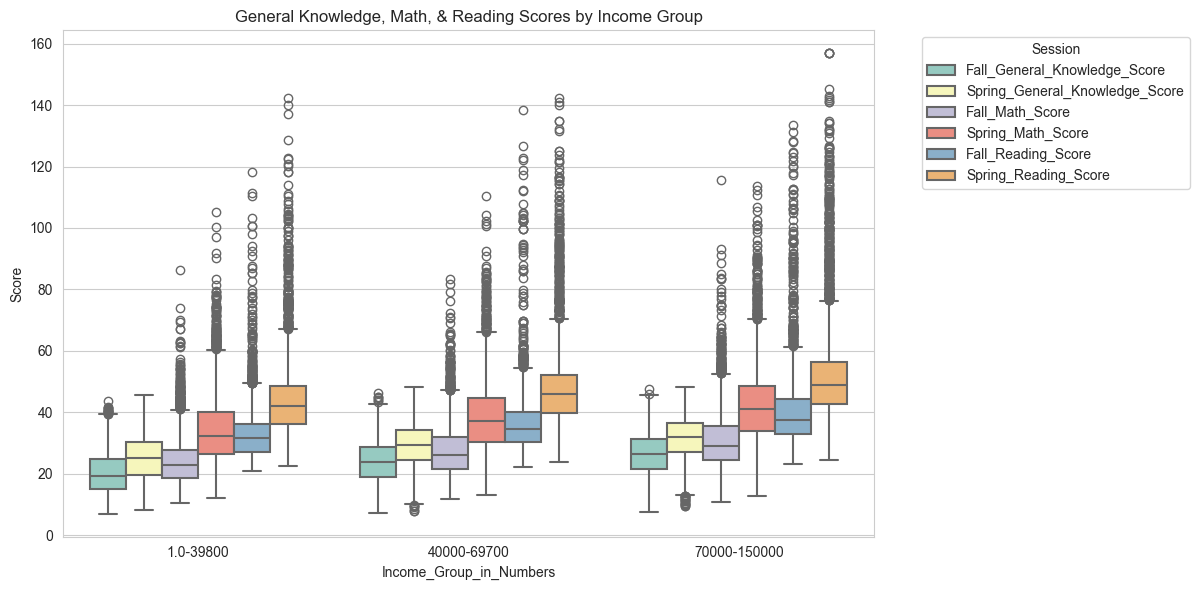

,Type,Income,IQR,Mean,Median
0,Fall_General_Knowledge_Score,1.0-39800,9.80300,19.947683,19.2980
1,Fall_Math_Score,1.0-39800,8.96000,23.924504,22.7900
2,Fall_Reading_Score,1.0-39800,8.95000,32.786798,31.6600
3,Spring_General_Knowledge_Score,1.0-39800,10.44700,25.069492,25.0650
4,Spring_Math_Score,1.0-39800,13.69000,33.883051,32.2700
5,Spring_Reading_Score,1.0-39800,12.43000,43.665077,41.9700
6,Fall_General_Knowledge_Score,40000-69700,9.78275,23.887885,23.8690
7,Fall_Math_Score,40000-69700,10.26000,27.568468,26.1400
8,Fall_Reading_Score,40000-69700,9.72750,36.292517,34.5300
9,Spring_General_Knowledge_Score,40000-69700,9.62300,29.143605,29.4760


In [11]:
income_group_order = ["1.0-39800", "40000-69700", "70000-150000"]
df["Income_Group_in_Numbers"] = pd.Categorical(df["Income_Group_in_Numbers"],
                                               categories=income_group_order,
                                               ordered=True)

melted_all_df = melt_me(df,"Session", "Score", ["Income_Group_in_Numbers"], ["Fall_General_Knowledge_Score", "Spring_General_Knowledge_Score",
"Fall_Math_Score", "Spring_Math_Score", "Fall_Reading_Score", "Spring_Reading_Score"])

the_stats = generate_box_plot(melted_data_frame=melted_all_df,
                  independent_var="Session", x_var="Income_Group_in_Numbers",
                  y_var="Score", figx=12, figy=6,
                  plot_title="General Knowledge, Math, & Reading Scores by Income Group",
                  legend_title="Session",
                  x_ticks_rotation=0, palette_val="Set3")

the_stats_df = pd.DataFrame(the_stats)
the_stats_df


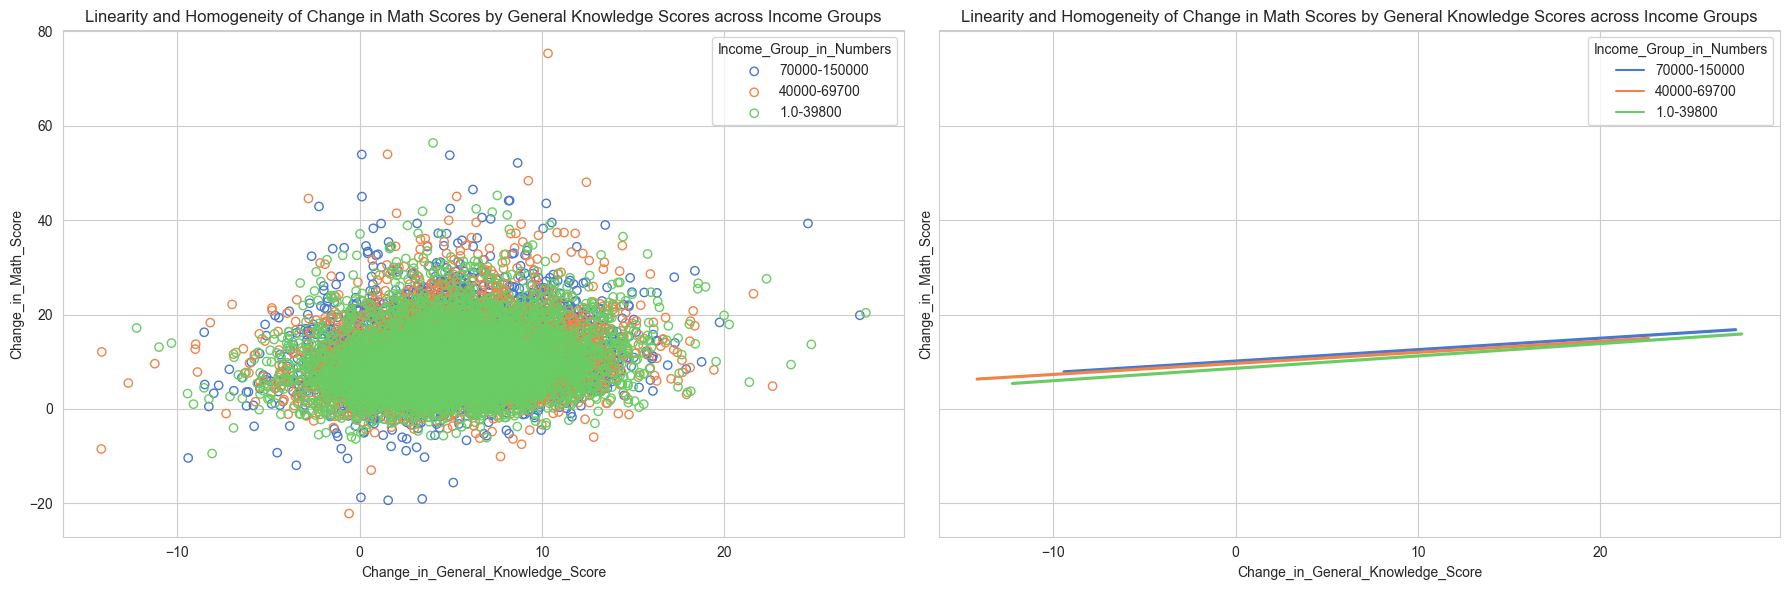

C:\Users\asada\AppData\Local\Temp\ipykernel_8168\1007299762.py:86: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11933.
  shapiro_test_results = stats.shapiro(residuals)


,Test,Statistic,p-value
0,Shapiro-Wilk (Change_in_Math_Score),0.999371,2.511487e-04
1,Levene (Change_in_Math_Score),22.215180,2.344180e-10


In [12]:
#Checking Assumptions:

#1. Linearity and Homogenity
check_linearity_homogeneity_subplots(data_frame=df, x_col='Change_in_General_Knowledge_Score', y_col="Change_in_Math_Score", hue_col="Income_Group_in_Numbers", title="Linearity and Homogeneity of Change in Math Scores by General Knowledge Scores across Income Groups")

#2. Run ANCOVA as our function returns various other things.
#[model, predictions, residuals, ancova_results]
math_ancova_results = run_ancova(df, "Change_in_Math_Score ~ C(Income_Group) + Change_in_General_Knowledge_Score")

#2. Shapiro-Wilks & Levene:
math_residuals = math_ancova_results[1]
shaprio_levene_math = run_shapiro_levene(data_frame=df, residuals=math_residuals, dependent_var="Change_in_Math_Score", independent_var="Income_Group_in_Numbers")

display(shaprio_levene_math)


In [13]:
#ANCOVA Summary (Math)
#return [model, predictions, residuals, ancova_results]

display(math_ancova_results[3])
display(math_ancova_results[0].summary())


,sum_sq,df,F,PR(>F)
C(Income_Group),4388.326834,2.0,48.089207,1.580759e-21
Change_in_General_Knowledge_Score,12022.654936,1.0,263.499036,1.257053e-58
Residual,544283.777802,11929.0,NaN,NaN


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Change_in_Math_Score   R-squared:                       0.029
Model:                              OLS   Adj. R-squared:                  0.029
Method:                   Least Squares   F-statistic:                     120.2
Date:                  Sat, 23 Mar 2024   Prob (F-statistic):           1.04e-76
Time:                          16:46:04   Log-Likelihood:                -39725.
No. Observations:                 11933   AIC:                         7.946e+04
Df Residuals:                     11929   BIC:                         7.949e+04
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             8.6905      0.126     69.246      0.000       8.444       8.936
C(Income_Group)[T.2]                  0.9045      0.148      6.112      0.000       0.614       1.195
C(Income_Group)[T.3]                  1.4421      0.151      9.557      0.000       1.146       1.738
Change_in_General_Knowledge_Score     0.2476      0.015     16.233      0.000       0.218       0.277
==============================================================================
Omnibus:                     2113.554   Durbin-Watson:                   1.816
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5992.048
Skew:                           0.942   Prob(JB):                         0.00
Kurtosis:                       5.916   Cond. No.                         21.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
#Running ANCOVA using pingouin library (just for testing purposes)
math_ancova_results_pg = pg.ancova(data=df, dv="Change_in_Math_Score", between="Income_Group_in_Numbers", covar="Change_in_General_Knowledge_Score")

display(math_ancova_results_pg)


,Source,SS,DF,F,p-unc,np2
0,Income_Group_in_Numbers,4388.326834,2,48.089207,1.580759e-21,0.007998
1,Change_in_General_Knowledge_Score,12022.654936,1,263.499036,1.257053e-58,0.021612
2,Residual,544283.777802,11929,NaN,NaN,NaN


In [15]:
#Perform Tukey's HSD on the residuals
#Conduct Tukey's HSD using residuals for math.
#Tukey compares the means of the residuals across income groups to see if there #are significant differences that remain after adjusting for the general #knowledge covariate.
math_tukey_hsd = pairwise_tukeyhsd(endog=math_ancova_results[2], groups=df["Income_Group_in_Numbers"], alpha=0.05)

# Print the results
math_tukey_hsd.summary()


group1,group2,meandiff,p-adj,lower,upper,reject
1.0-39800,40000-69700,-0.0,1.0,-0.3468,0.3468,False
1.0-39800,70000-150000,-0.0,1.0,-0.3537,0.3537,False
40000-69700,70000-150000,0.0,1.0,-0.3733,0.3733,False


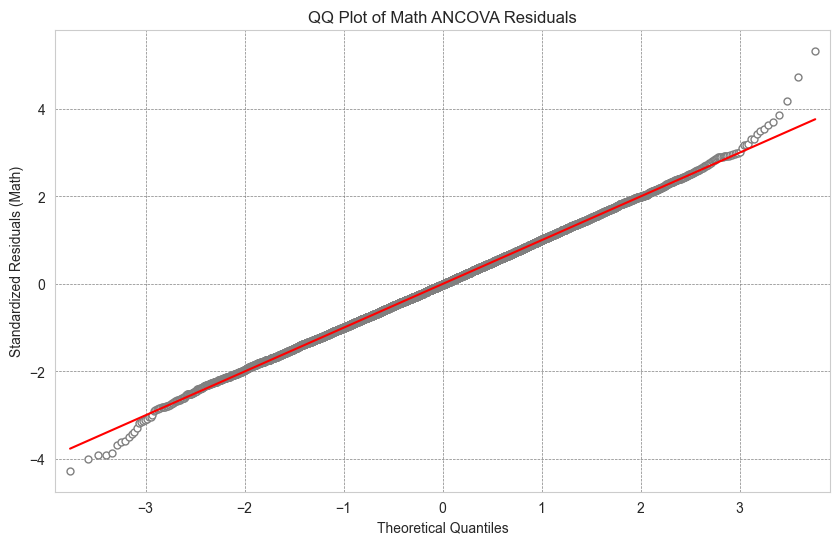

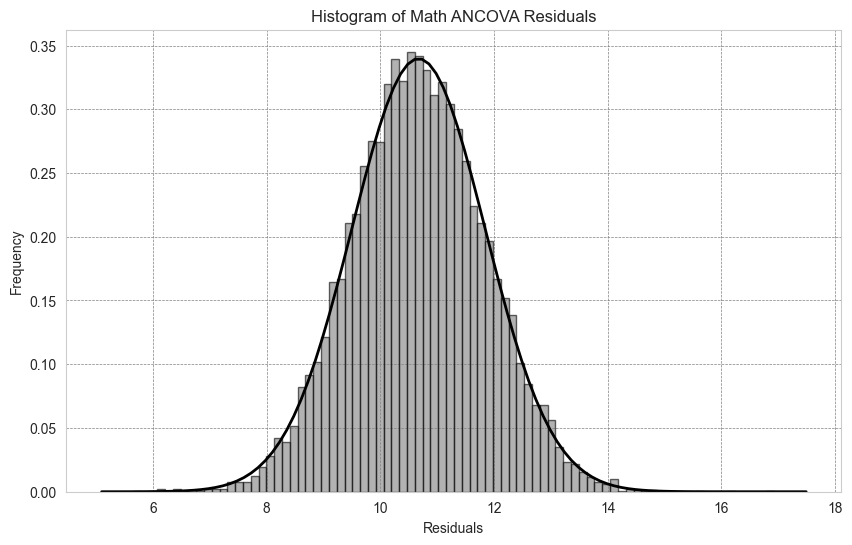

In [16]:
#return [model, predictions, residuals, ancova_results]
generate_qq_plot(math_residuals, "QQ Plot of Math ANCOVA Residuals", "Math")
generate_histogram(math_residuals,"Histogram of Math ANCOVA Residuals")


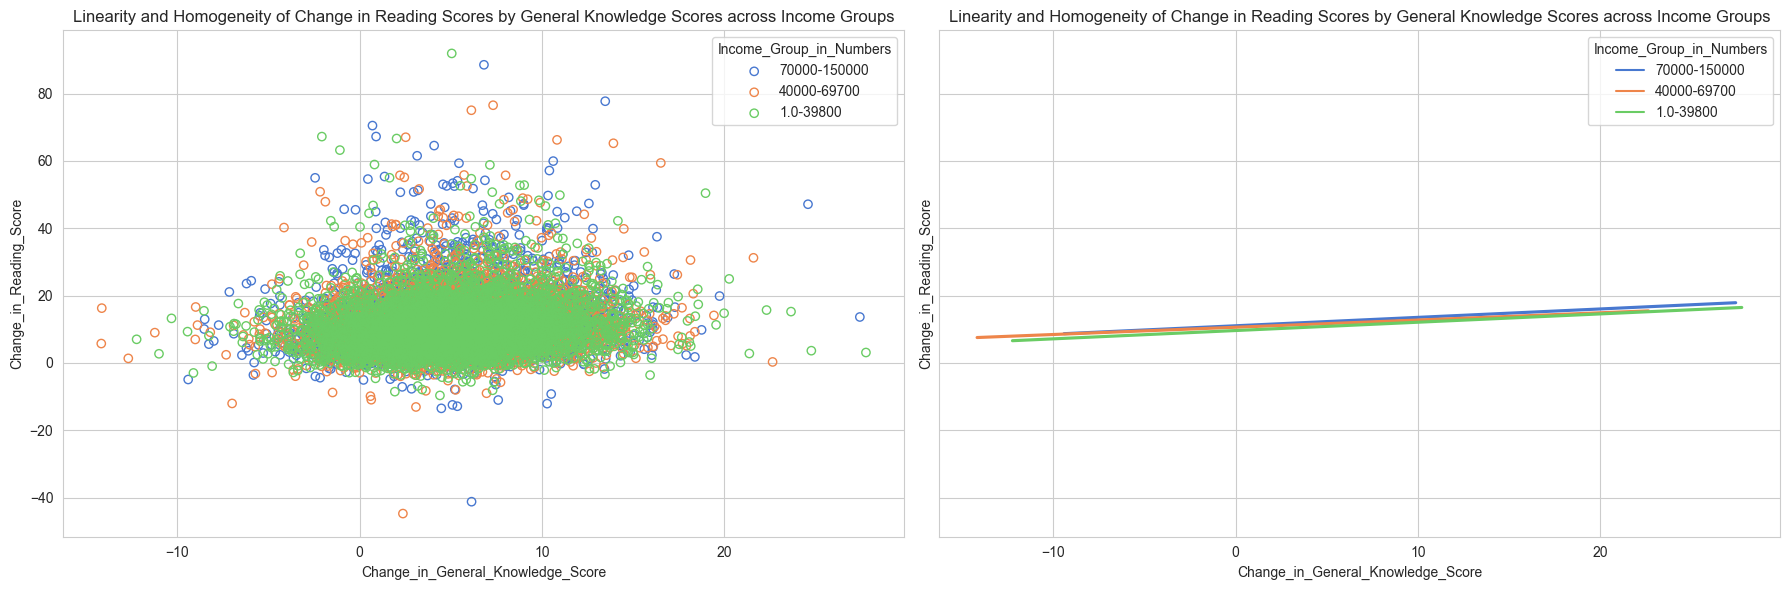

C:\Users\asada\AppData\Local\Temp\ipykernel_8168\1007299762.py:86: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11933.
  shapiro_test_results = stats.shapiro(residuals)


,Test,Statistic,p-value
0,Shapiro-Wilk (Change_in_Reading_Score),0.999371,2.511487e-04
1,Levene (Change_in_Reading_Score),19.728010,2.794930e-09


In [17]:
#Checking Assumptions:

#1. Linearity and Homogenity
check_linearity_homogeneity_subplots(data_frame=df, x_col='Change_in_General_Knowledge_Score', y_col="Change_in_Reading_Score", hue_col="Income_Group_in_Numbers", title="Linearity and Homogeneity of Change in Reading Scores by General Knowledge Scores across Income Groups")

#2. Run ANCOVA as our function returns various other things.
#[model, predictions, residuals, ancova_results]
reading_ancova_results = run_ancova(df, "Change_in_Reading_Score ~ C(Income_Group) + Change_in_General_Knowledge_Score")

#2. Shapiro-Wilks & Levene:
reading_residuals = math_ancova_results[1]
shaprio_levene_reading = run_shapiro_levene(data_frame=df, residuals=reading_residuals, dependent_var="Change_in_Reading_Score", independent_var="Income_Group_in_Numbers")

display(shaprio_levene_reading)


In [18]:
#ANCOVA Summary (Reading)

display(reading_ancova_results[3])
display(reading_ancova_results[0].summary())
#return [model, predictions, residuals, ancova_results]


,sum_sq,df,F,PR(>F)
C(Income_Group),4209.528531,2.0,32.835548,6.009132e-15
Change_in_General_Knowledge_Score,11074.220434,1.0,172.764288,3.448471e-39
Residual,764650.940643,11929.0,NaN,NaN


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Change_in_Reading_Score   R-squared:                       0.020
Model:                                 OLS   Adj. R-squared:                  0.019
Method:                      Least Squares   F-statistic:                     79.62
Date:                     Sat, 23 Mar 2024   Prob (F-statistic):           5.38e-51
Time:                             16:46:05   Log-Likelihood:                -41754.
No. Observations:                    11933   AIC:                         8.352e+04
Df Residuals:                        11929   BIC:                         8.354e+04
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             9.6613      0.149     64.948      0.000       9.370       9.953
C(Income_Group)[T.2]                  0.8068      0.175      4.600      0.000       0.463       1.151
C(Income_Group)[T.3]                  1.4315      0.179      8.004      0.000       1.081       1.782
Change_in_General_Knowledge_Score     0.2376      0.018     13.144      0.000       0.202       0.273
==============================================================================
Omnibus:                     4797.228   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37856.815
Skew:                           1.731   Prob(JB):                         0.00
Kurtosis:                      11.010   Cond. No.                         21.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
#Running ANCOVA using pingouin library (just for testing purposes)
reading_ancova_results_pg = pg.ancova(data=df, dv="Change_in_Reading_Score", between="Income_Group_in_Numbers", covar="Change_in_General_Knowledge_Score")

display(reading_ancova_results_pg)


,Source,SS,DF,F,p-unc,np2
0,Income_Group_in_Numbers,4209.528531,2,32.835548,6.009132e-15,0.005475
1,Change_in_General_Knowledge_Score,11074.220434,1,172.764288,3.448471e-39,0.014276
2,Residual,764650.940643,11929,NaN,NaN,NaN


In [20]:
#Perform Tukey's HSD on the residuals
#Conduct Tukey's HSD using residuals for reading.
#Tukey compares the means of the residuals across income groups to see if there #are significant differences that remain after adjusting for the general #knowledge covariate.
reading_tukey_hsd = pairwise_tukeyhsd(endog=reading_ancova_results[2], groups=df["Income_Group_in_Numbers"], alpha=0.05)

# Print the results
reading_tukey_hsd.summary()


group1,group2,meandiff,p-adj,lower,upper,reject
1.0-39800,40000-69700,-0.0,1.0,-0.4111,0.4111,False
1.0-39800,70000-150000,-0.0,1.0,-0.4192,0.4192,False
40000-69700,70000-150000,0.0,1.0,-0.4425,0.4425,False


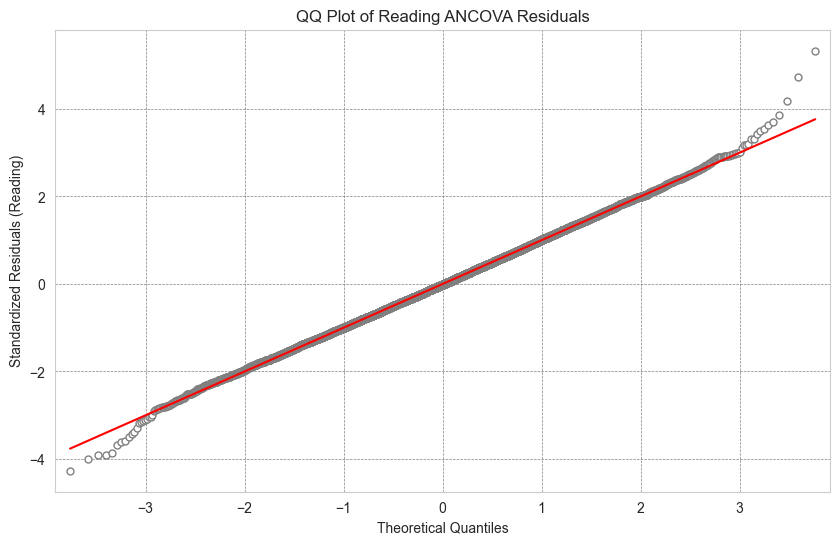

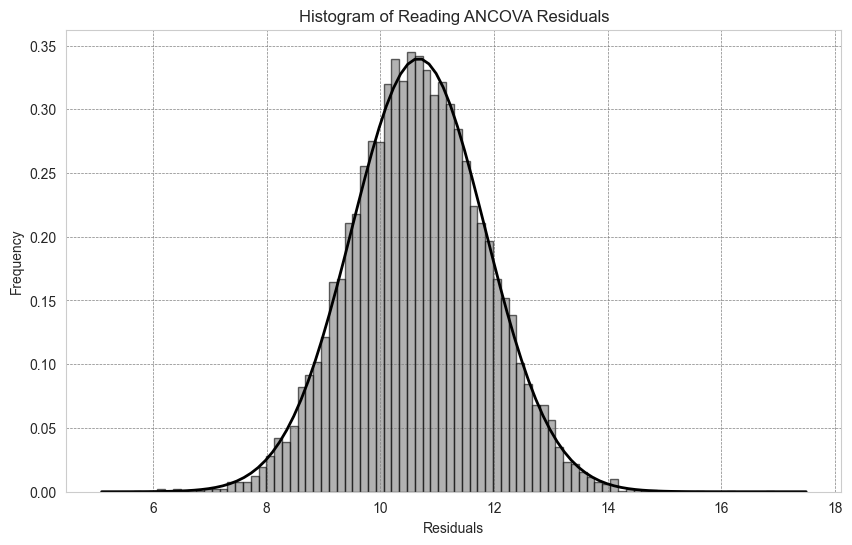

In [21]:
#return [model, predictions, residuals, ancova_results]
generate_qq_plot(reading_residuals, "QQ Plot of Reading ANCOVA Residuals", "Reading")
generate_histogram(reading_residuals,"Histogram of Reading ANCOVA Residuals")


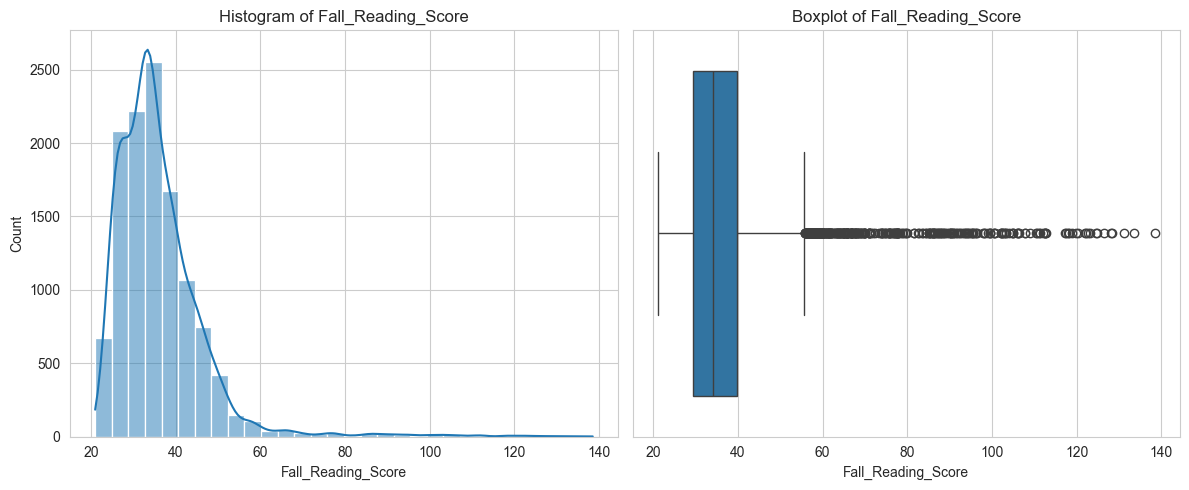

Statistics for Fall_Reading_Score:


,Mean,Median,Quartile1,Quartile3,IQR
0,35.954215,34.06,29.34,39.89,10.55


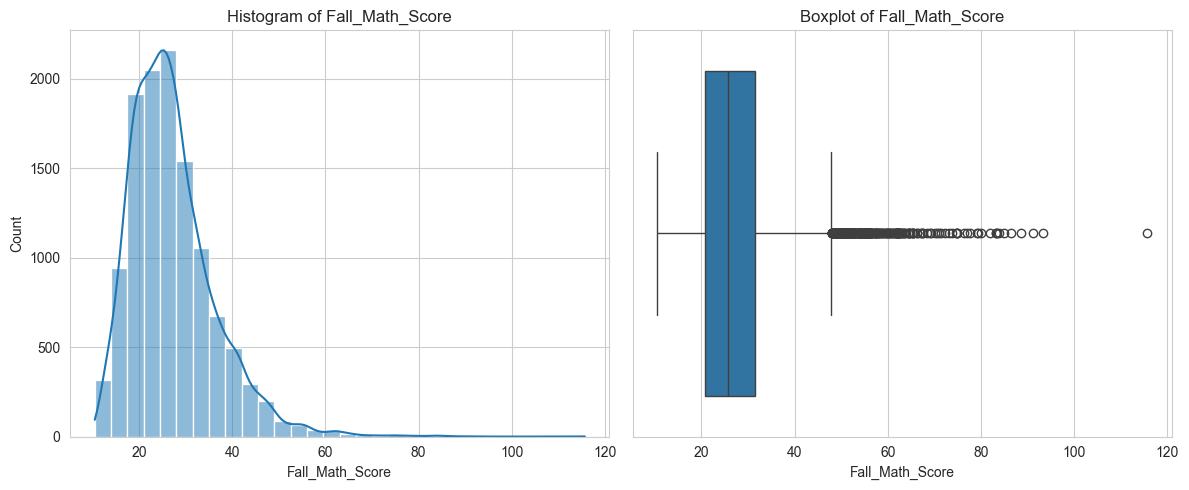

Statistics for Fall_Math_Score:


,Mean,Median,Quartile1,Quartile3,IQR
0,27.128244,25.68,20.68,31.59,10.91


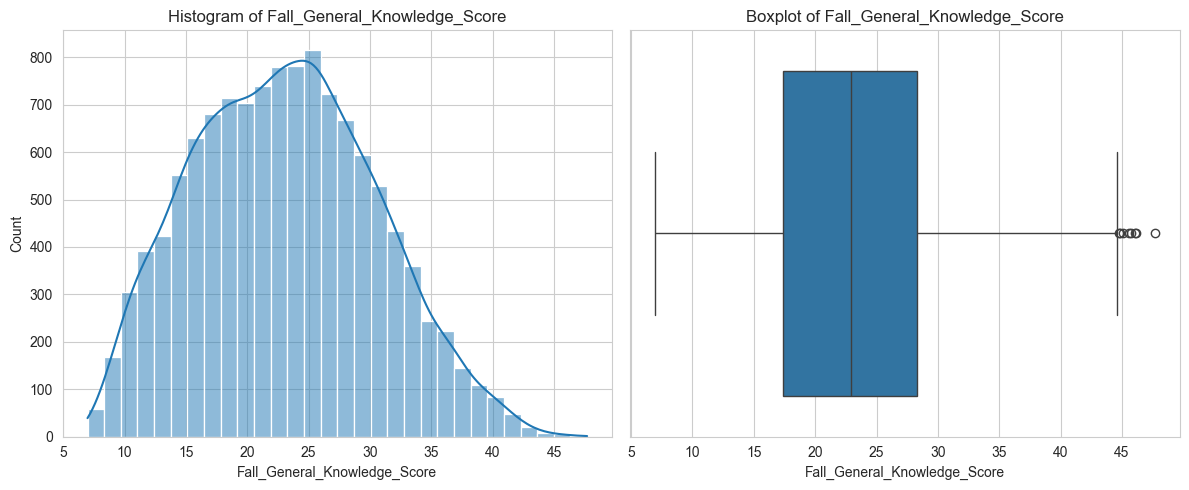

Statistics for Fall_General_Knowledge_Score:


,Mean,Median,Quartile1,Quartile3,IQR
0,23.073694,22.954,17.385,28.305,10.92


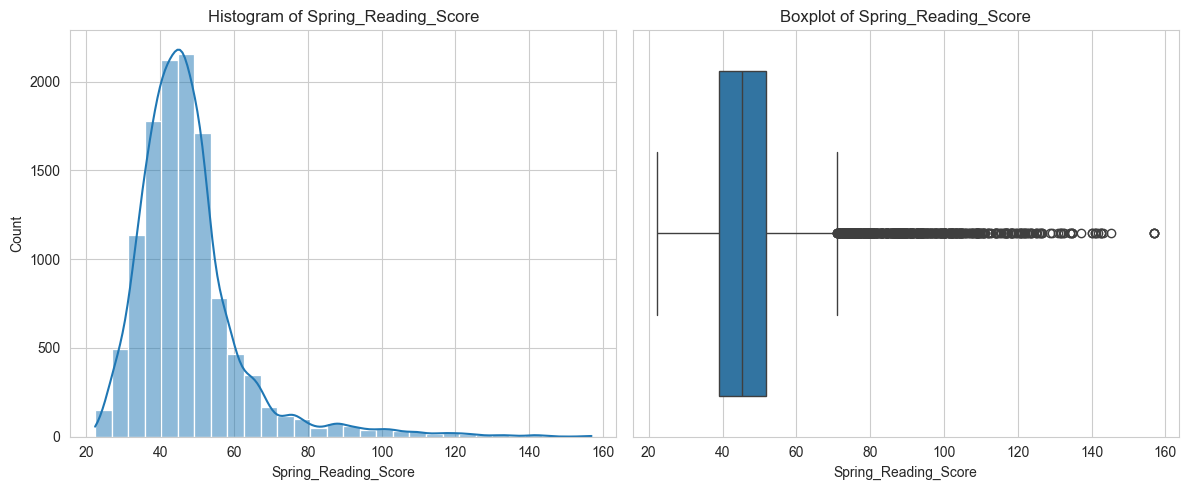

Statistics for Spring_Reading_Score:


,Mean,Median,Quartile1,Quartile3,IQR
0,47.511178,45.32,38.95,51.77,12.82


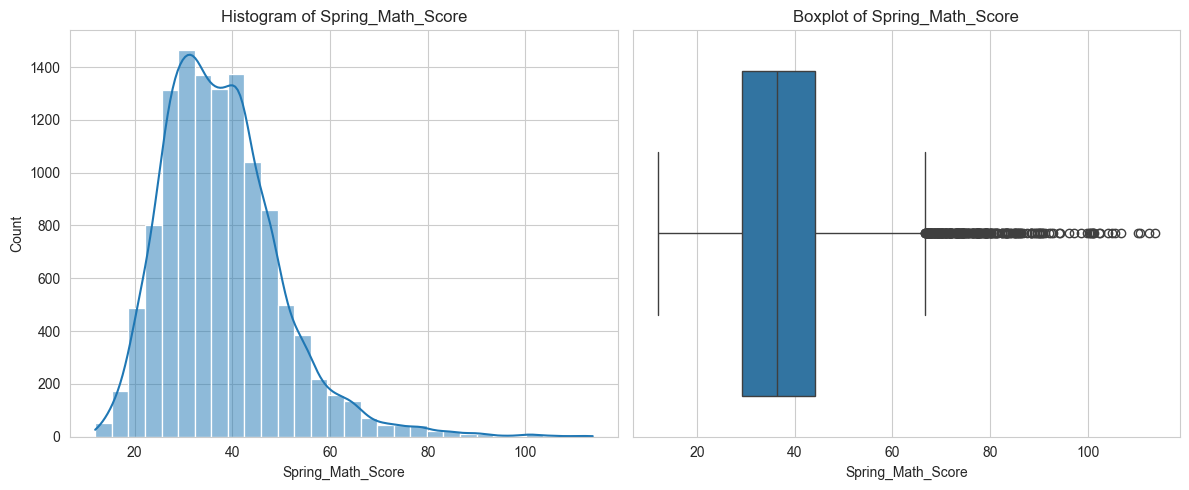

Statistics for Spring_Math_Score:


,Mean,Median,Quartile1,Quartile3,IQR
0,37.799461,36.41,29.27,44.22,14.95


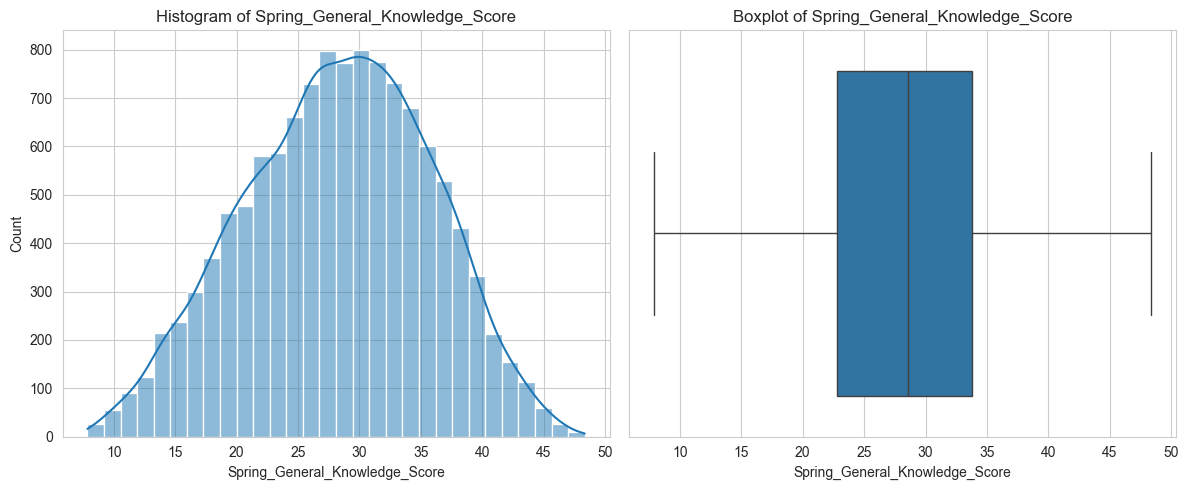

Statistics for Spring_General_Knowledge_Score:


,Mean,Median,Quartile1,Quartile3,IQR
0,28.235584,28.583,22.802,33.782,10.98


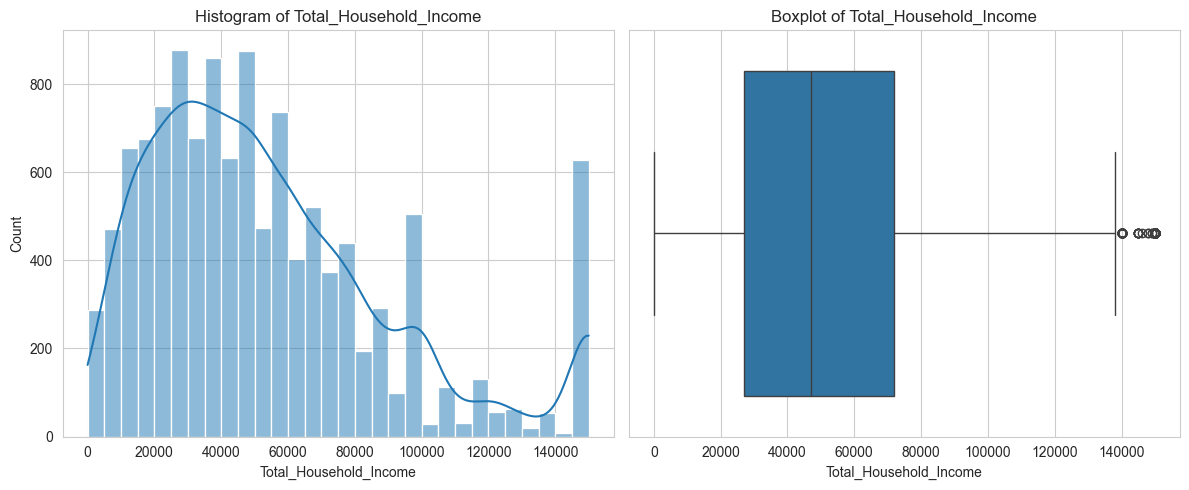

Statistics for Total_Household_Income:


,Mean,Median,Quartile1,Quartile3,IQR
0,54317.19993,47000.0,27000.0,72000.0,45000.0


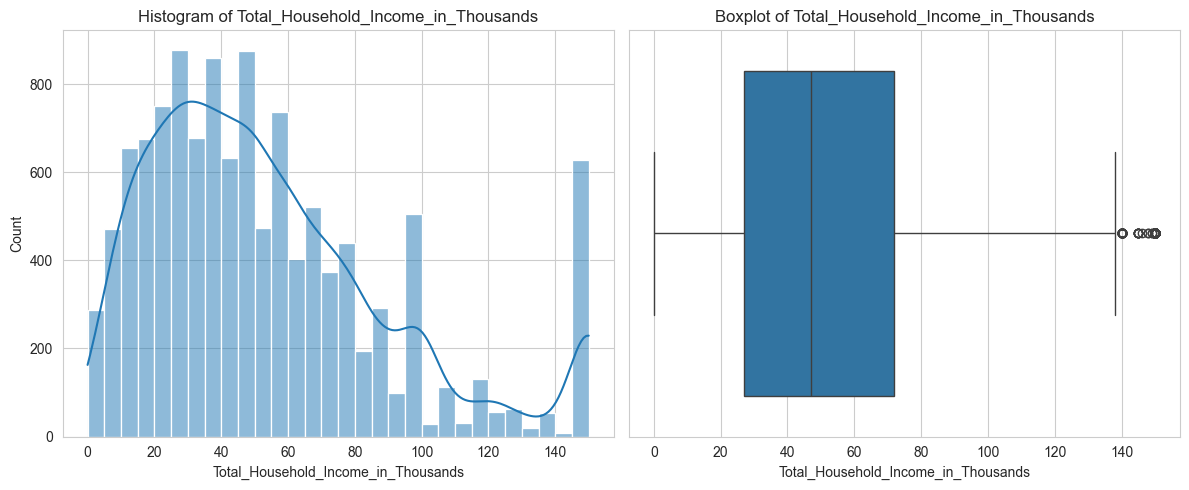

Statistics for Total_Household_Income_in_Thousands:


,Mean,Median,Quartile1,Quartile3,IQR
0,54.3172,47.0,27.0,72.0,45.0


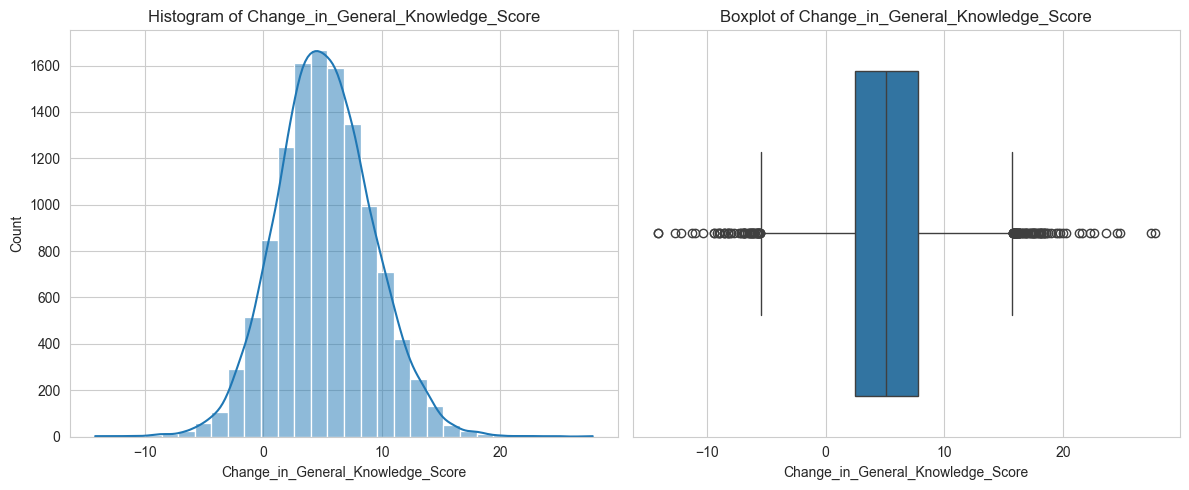

Statistics for Change_in_General_Knowledge_Score:


,Mean,Median,Quartile1,Quartile3,IQR
0,5.16189,5.047,2.472,7.781,5.309


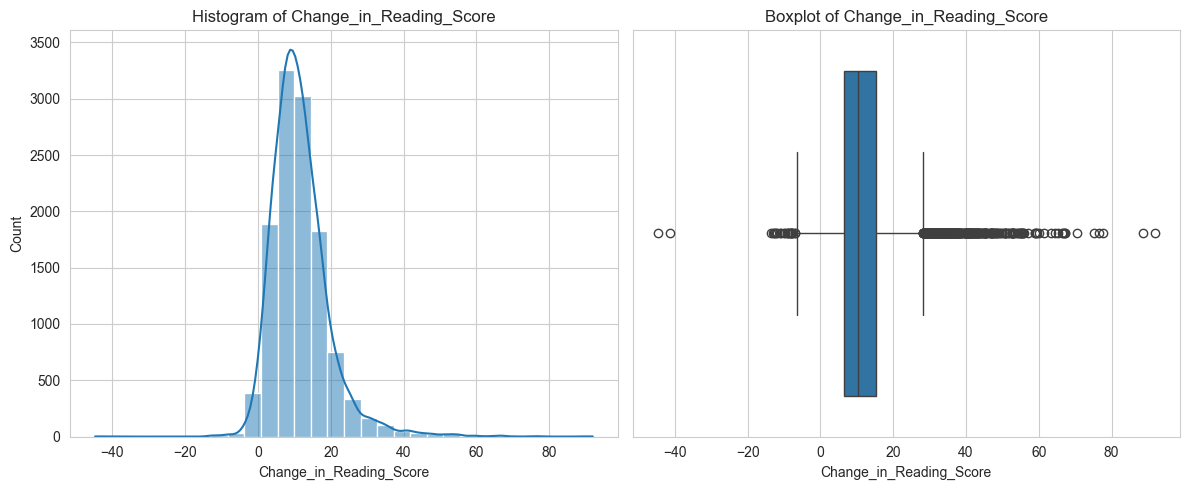

Statistics for Change_in_Reading_Score:


,Mean,Median,Quartile1,Quartile3,IQR
0,11.556963,10.4,6.47,15.15,8.68


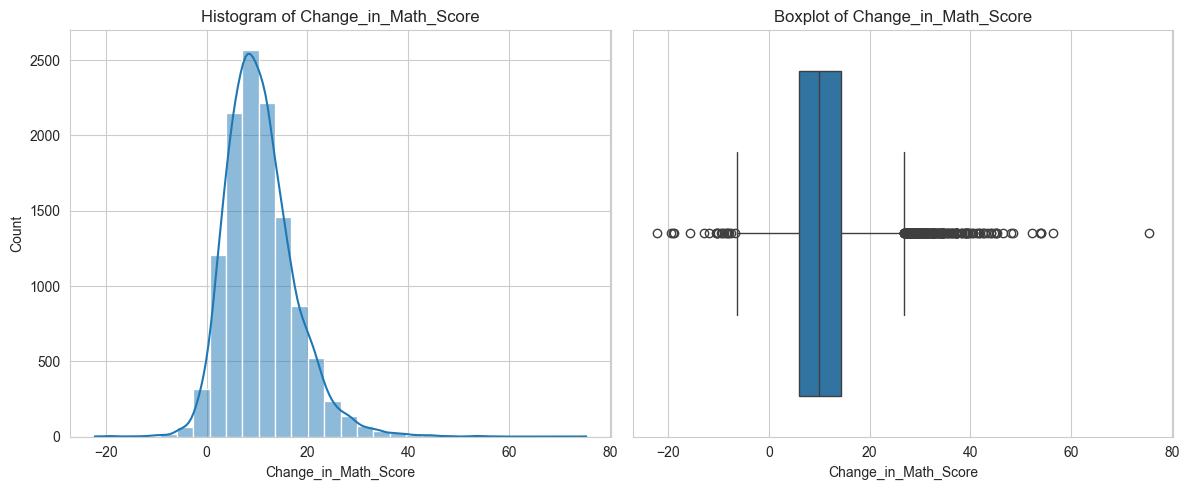

Statistics for Change_in_Math_Score:


,Mean,Median,Quartile1,Quartile3,IQR
0,10.671218,9.86,6.01,14.33,8.32


In [22]:
for continous_col in continous_cols:
    return_data = is_col_normal(df, continous_col)
    return_data_df = pd.DataFrame([return_data])
    print(f"Statistics for {continous_col}:")
    display(return_data_df)


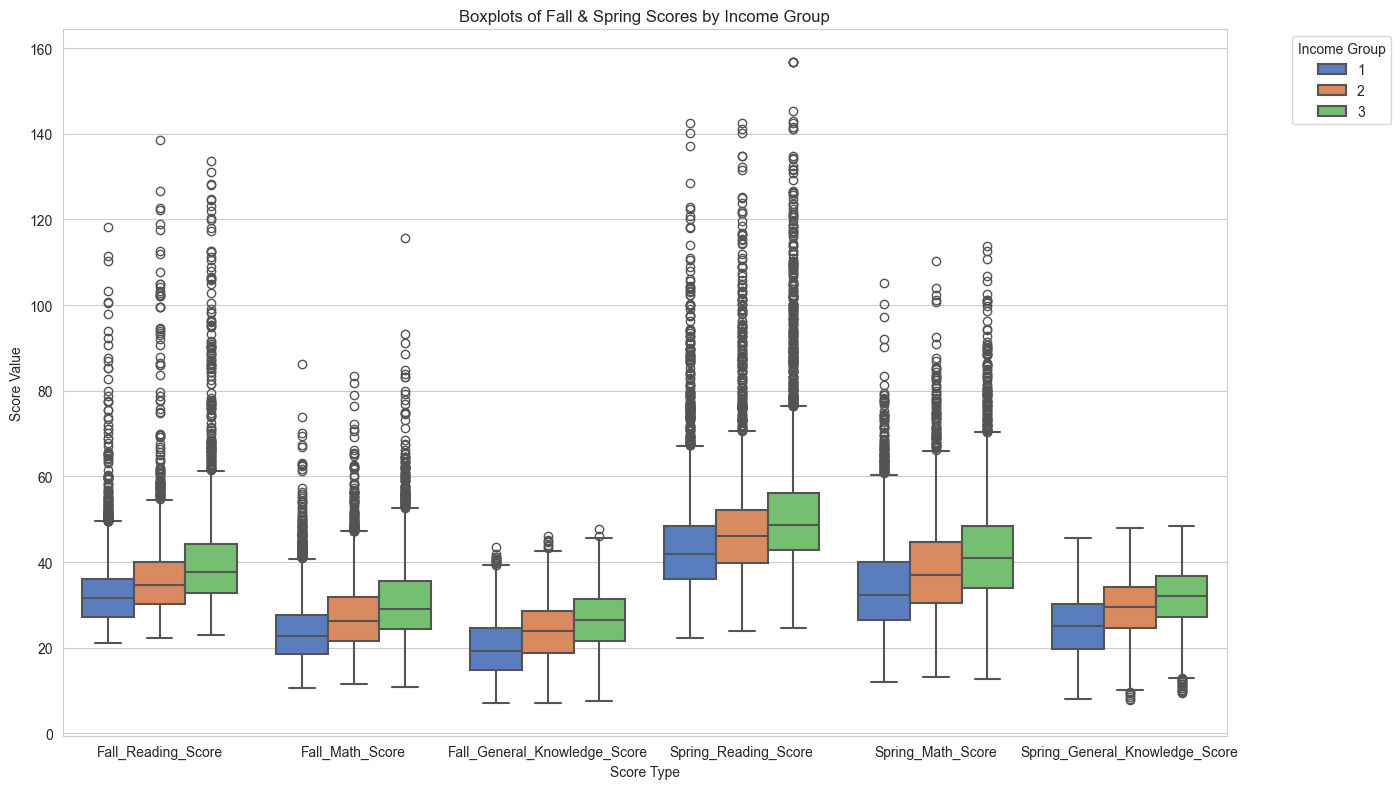

[{'Type': 1,
  'Income': 'Fall_General_Knowledge_Score',
  'IQR': 9.803,
  'Mean': 19.947683231127087,
  'Median': 19.298},
 {'Type': 2,
  'Income': 'Fall_General_Knowledge_Score',
  'IQR': 9.78275,
  'Mean': 23.887884594739667,
  'Median': 23.869},
 {'Type': 3,
  'Income': 'Fall_General_Knowledge_Score',
  'IQR': 9.760499999999997,
  'Mean': 26.45185135135135,
  'Median': 26.505499999999998},
 {'Type': 1,
  'Income': 'Fall_Math_Score',
  'IQR': 8.96,
  'Mean': 23.92450412349334,
  'Median': 22.79},
 {'Type': 2,
  'Income': 'Fall_Math_Score',
  'IQR': 10.260000000000002,
  'Mean': 27.568467525496512,
  'Median': 26.14},
 {'Type': 3,
  'Income': 'Fall_Math_Score',
  'IQR': 11.295000000000002,
  'Mean': 31.01271995399655,
  'Median': 29.085},
 {'Type': 1,
  'Income': 'Fall_Reading_Score',
  'IQR': 8.949999999999996,
  'Mean': 32.78679847747938,
  'Median': 31.66},
 {'Type': 2,
  'Income': 'Fall_Reading_Score',
  'IQR': 9.7275,
  'Mean': 36.292517444981215,
  'Median': 34.53},
 {'Type': 3

In [23]:
fall_scores = df[["Fall_Reading_Score", "Fall_Math_Score",
                  "Fall_General_Knowledge_Score", "Income_Group"]]

spring_scores = df[["Spring_Reading_Score", "Spring_Math_Score",
                    "Spring_General_Knowledge_Score", "Income_Group"]]

# Melt the dataframes
fall_scores_melted = pd.melt(fall_scores, id_vars=["Income_Group"],
                             var_name="Score Type", value_name="Score Value")

spring_scores_melted = pd.melt(spring_scores, id_vars=["Income_Group"],
                               var_name="Score Type", value_name="Score Value")

# Combine fall and spring data
fall_scores_melted["Season"] = "Fall"
spring_scores_melted["Season"] = "Spring"
fall_spring_scores_melted = pd.concat([fall_scores_melted, spring_scores_melted])

generate_box_plot(fall_spring_scores_melted, "Income_Group",
                  "Score Type", "Score Value", 14, 8, "Boxplots of Fall & Spring Scores by Income Group", "Income Group", 0, "muted")


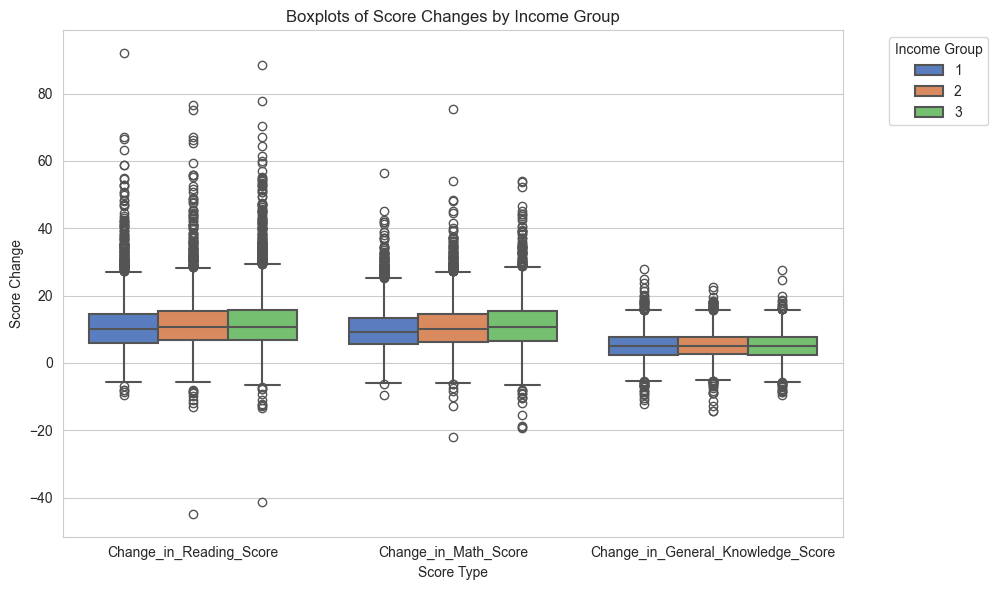

[{'Type': 1,
  'Income': 'Change_in_General_Knowledge_Score',
  'IQR': 5.288,
  'Mean': 5.121809262000423,
  'Median': 4.975999999999999},
 {'Type': 2,
  'Income': 'Change_in_General_Knowledge_Score',
  'IQR': 5.22025,
  'Mean': 5.255720343531937,
  'Median': 5.151499999999999},
 {'Type': 3,
  'Income': 'Change_in_General_Knowledge_Score',
  'IQR': 5.429500000000002,
  'Mean': 5.115866302472686,
  'Median': 5.040000000000001},
 {'Type': 1,
  'Income': 'Change_in_Math_Score',
  'IQR': 7.900000000000002,
  'Mean': 9.9585472615775,
  'Median': 9.040000000000003},
 {'Type': 2,
  'Income': 'Change_in_Math_Score',
  'IQR': 8.237499999999997,
  'Mean': 10.89622383252818,
  'Median': 10.219999999999999},
 {'Type': 3,
  'Income': 'Change_in_Math_Score',
  'IQR': 8.890000000000008,
  'Mean': 11.399177688326624,
  'Median': 10.599999999999994},
 {'Type': 1,
  'Income': 'Change_in_Reading_Score',
  'IQR': 8.470000000000006,
  'Mean': 10.878278705857475,
  'Median': 9.990000000000002},
 {'Type': 2,

In [24]:
score_changes = df[["Change_in_Reading_Score",
                    "Change_in_Math_Score", "Change_in_General_Knowledge_Score", "Income_Group"]]

score_changes_melted = pd.melt(score_changes, id_vars=["Income_Group"],
                               var_name="Score Type", value_name="Score Change")

generate_box_plot(score_changes_melted,"Income_Group", "Score Type",
                  "Score Change", 10, 6, "Boxplots of Score Changes by Income Group", "Income Group", 0, "muted")


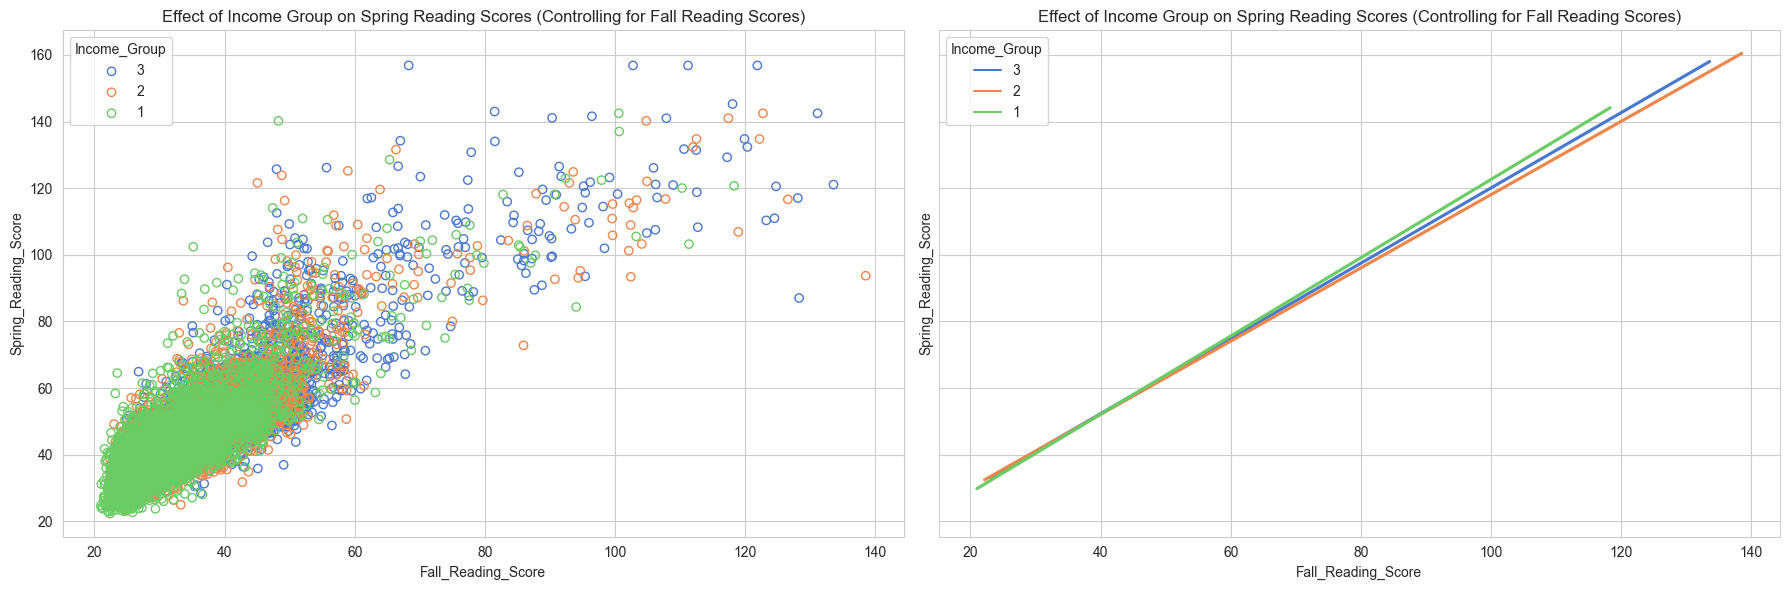

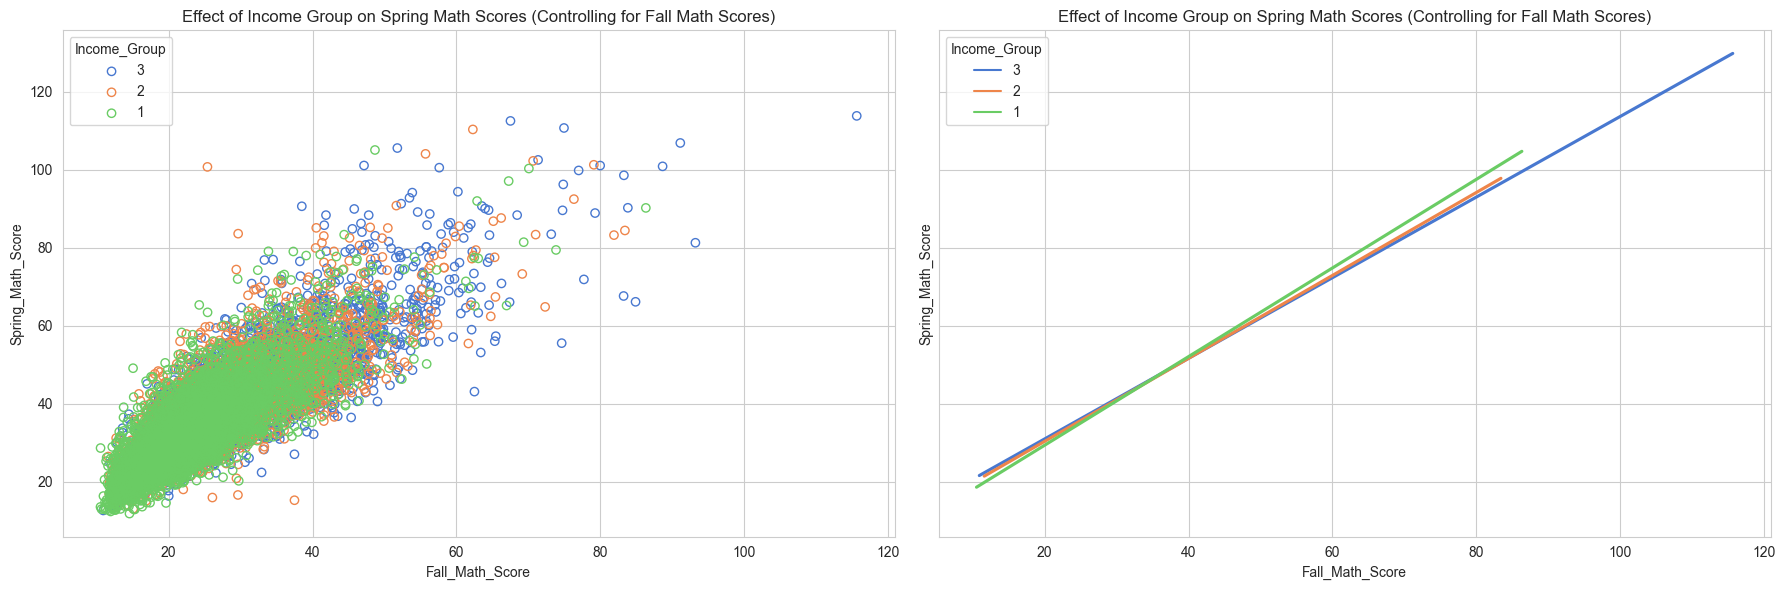

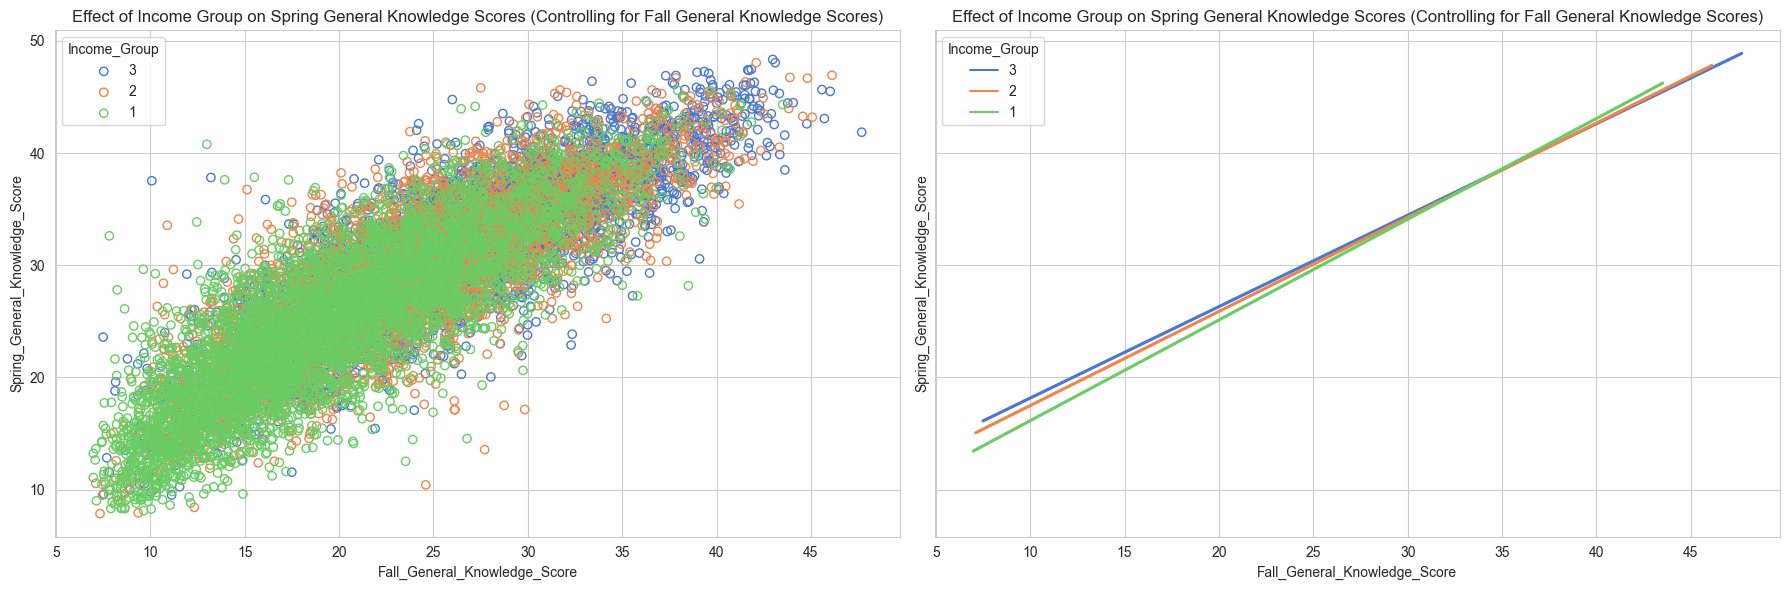

In [25]:
# Checking for linearity and homogeneity of regression slopes visually

# Question:
# What is the effect of a child's income group on their spring reading score controlling for their fall reading score.
#dependent_var: Spring_Reading_Score
#independent_var: Income_Group
#control_var: Fall_Reading_Score
check_linearity_homogeneity_subplots(df, "Fall_Reading_Score",
                            "Spring_Reading_Score", "Income_Group", "Effect of Income Group on Spring Reading Scores (Controlling for Fall Reading Scores)")

# Question:
# What is the effect of a child's income group on their spring math score controlling for their fall math score.
#dependent_var: Spring_Math_Score
#independent_var: Income_Group
#control_var: Fall_Math_Score
check_linearity_homogeneity_subplots(df, "Fall_Math_Score",
                            "Spring_Math_Score", "Income_Group", "Effect of Income Group on Spring Math Scores (Controlling for Fall Math Scores)")

# Question:
# What is the effect of a child's income group on their spring general knowledge score controlling for their fall general knowledge score.
#dependent_var: Spring_General_Knowledge_Score
#independent_var: Income_Group
#control_var: Fall_General_Knowledge_Score
check_linearity_homogeneity_subplots(df, "Fall_General_Knowledge_Score",
                            "Spring_General_Knowledge_Score",
                            "Income_Group", "Effect of Income Group on Spring General Knowledge Scores (Controlling for Fall General Knowledge Scores)")
